In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

alpha = 1 # proximal term coefficient

num_resources = 50
num_agents = num_participants = 100

filename = "local_resal_N%d_%.2f_n%d_m%d"%(num_points, eps_sublevel, num_agents, num_resources)

In [4]:

num_resource_per_participant = 10
inner_size = 5

A_all, A_ineq, b_ineq = mra.resal_data(num_resources, num_participants, inner_size)

In [5]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_solution_resal(A_all, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-91.86415947258942


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

1.0000000208130848

In [8]:
true_x.shape, true_lamb.shape

((5000, 1), (50, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions(lamb_k, i, A_all,  
                                                                           eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions_noisy_prices(lamb_k, i, A_all,
                                                                        percent=percent, K=K)]

fun_obj_val = lambda x_k: mra.resal_obj_value(x_k, A_all)

# Localization

In [10]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [11]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

/Users/parshakova.tanya/Documents/projects/mra_precovery/mra/localization_prim_rec.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.3687E-03,  viol_xk=4.2108E+02, viol_mra=2.9336E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=2.2952E-02,  f_subopt_mra=5.9896E-03,  viol_xk=9.1192E+01, viol_mra=8.8193E+00, lamb_rel_diff=1.3380E-01
epoch=99, f_subopt_xk=9.3175E-03,  f_subopt_mra=4.1222E-03,  viol_xk=6.6936E+01, viol_mra=1.2660E+00, lamb_rel_diff=6.7474E-02
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.0938E-02,  viol_xk=4.2108E+02, viol_mra=4.0431E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=2.2952E-02,  f_subopt_mra=2.9017E-02,  viol_xk=9.1192E+01, viol_mra=4.3302E+01, lamb_rel_diff=1.3380E-01
epoch=99, f_subopt_xk=9.3175E-03,  f_subopt_mra=3.2423E-03,  viol_xk=6.6936E+01, viol_mra=1.5747E+01, lamb_rel_diff=6.7474E-02


In [17]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [18]:
T = 100
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
idx_noisy_y = np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][:T])/ b_norm < 1e-8)[0][0]
idx_eps = 25#np.where(np.array(all_results_eps["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]

print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk] / b_norm,
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps]/ b_norm,
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y]/ b_norm,
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage]/ b_norm)

idx_xk=95, idx_eps=25, idx_noisy_y=92, idx_paverage=99
xk 0.031598475474895533 sub_eps 0.011988713108573855 noisy_y 0.0014536457921290188 proj inf paverage 0.016544497197419735
xk 0.16646445979475066 sub_eps 2.843508521374714e-10 noisy_y 9.945097140682451e-11 paverage 0.07241620703156212


In [ ]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)


In [7]:
import pickle

with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)

all_results_eps, all_results_noisy_y = res["eps"], res["noisy_y"]
T = 100

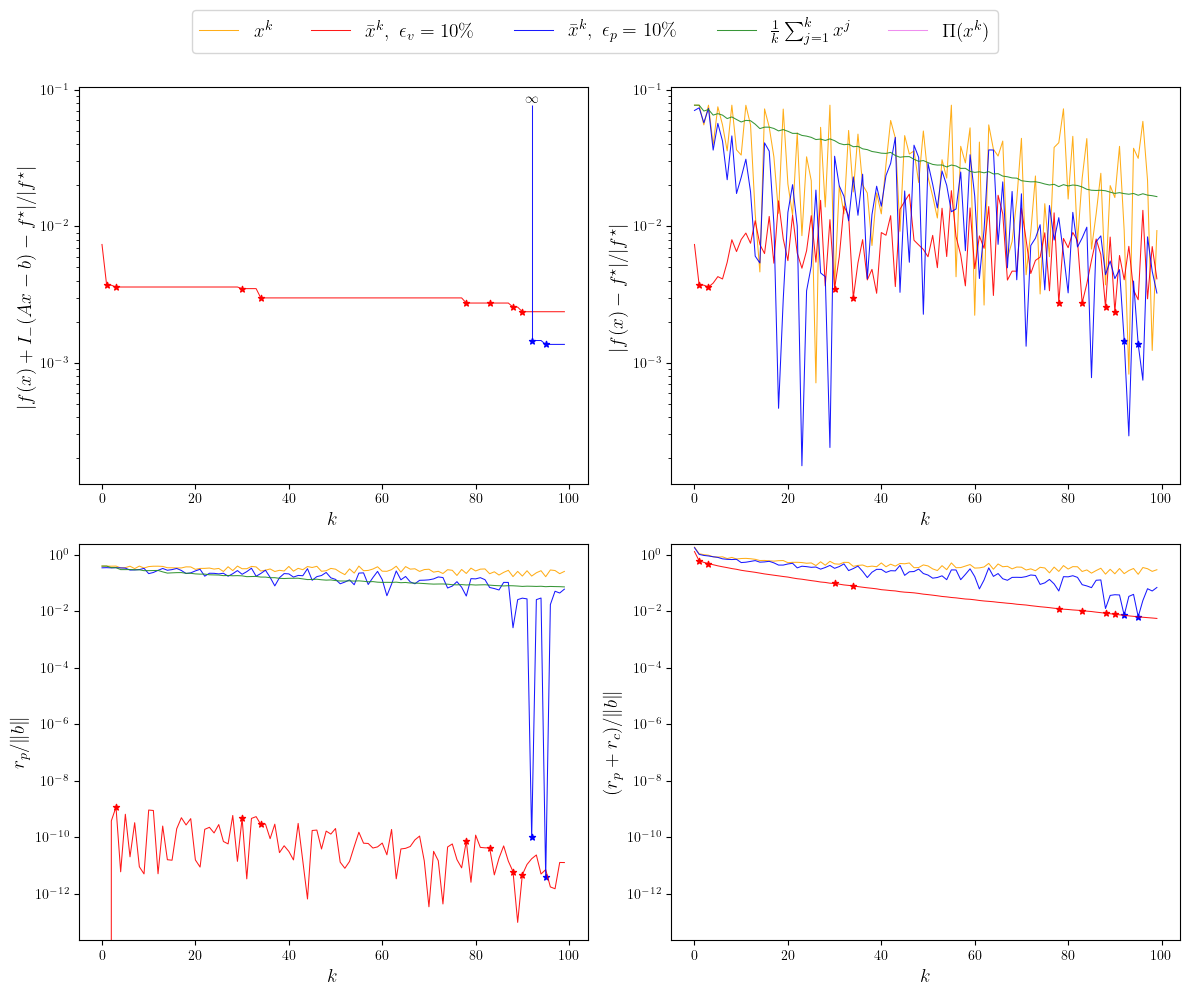

In [8]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T)